<div style="float:left">
    <h1 style="width:450px">Live Coding 6: Spatial Data</h1>
    <h2 style="width:450px">New types of pandas!</h2>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

<div style="border: dotted 1px rgb(156,121,26); padding: 10px; margin: 5px; background-color: rgb(255,236,184)"><i>Note</i>: You should download this notebook from GitHub and then save it to your own copy of the repository. I'd suggest adding it (<tt>git add Live-...</tt>) right away and then committing (<tt>git commit -m "Some message"</tt>). Do this again at the end of the class and you'll have a record of everything you did, then you can <tt>git push</tt> it to GitHub.</div>

## Preamble

Useful libraries to pre-load:

In [75]:
import os
import pandas as pd
import matplotlib.pyplot as plt

## Task 1. Orientation

You will really want to bookmark is [the official web site](https://geopandas.org/index.html) since you will undoubtedly need to refer to it fairly regularly. _Note_: this link is to the most recent release. Over time there will be updates published and you _may_ find that you no longer have the most up-to-date version.

You can always check what version you have installed like this:

In [3]:
import geopandas as gpd
print(gpd.__version__)

0.8.1


### Task 1.1: Loading Geo-Data

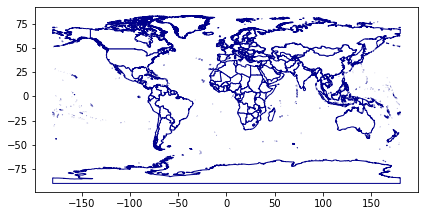

In [37]:
gpkg_src = 'https://github.com/jreades/i2p/blob/master/data/src/TM_WORLD_BORDERS-0.3.gpkg?raw=true'
world = gpd.read_file(gpkg_src)
world.plot(facecolor='white', edgecolor='darkblue')
plt.tight_layout()

plt.savefig(os.path.join('..','..','i2p','lectures','img','World_Demo.png'), dpi=150)

### Task 1.2: Checking the Projection

In [7]:
print(world.crs)

epsg:4326


### Task 1.3: Reprojection

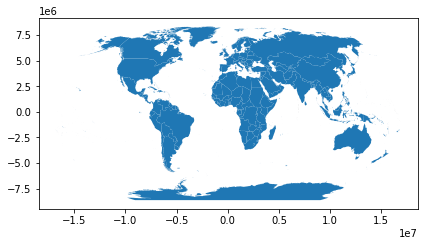

In [36]:
world2 = world.to_crs('ESRI:54030')
world2.plot()
plt.tight_layout()

## Task 2. The GeoSeries
The official documentation for `GeoSeries` is [here](https://geopandas.org/reference/geopandas.GeoSeries.html). Clearly, it will _have_ to work a bit differently from a 'normal' Series, but the basic idea holds that: 

> _"a Series is a one-dimensional object similar to an array, list, or column in a table. It will assign a labelled index to each item in the Series. By default, each item will receive an index label from 0 to N, where N is the length of the Series minus one."_ 
> [Greg Reda](http://www.gregreda.com/2013/10/26/intro-to-pandas-data-structures/)

### Task 2.1: Working with a GeoSeries

Although it's possible to [create a GeoSeries manually](https://geopandas.org/geometric_manipulations.html?highlight=buffer#examples-of-geometric-manipulations) and it can be useful to know how do so when data is in a really unusual format or you [want to create a clipping bounding box](https://geopandas.org/gallery/plot_clip.html#get-or-create-example-data), but most of the time we'll get it from loading data or converting it from a well-known format (ie. WKT). Geo-indexing necessarily works a _bit_ differently to what we have used in the past:

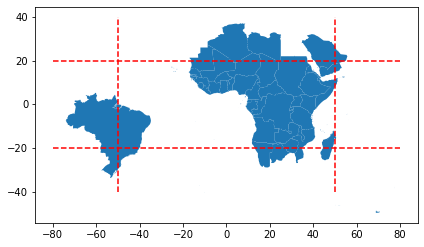

In [35]:
wslice = world.cx[-50:50, -20:20]
ax = wslice.plot()
plt.hlines(-20, -80, 80, colors='red', linestyles="dashed")
plt.hlines(20, -80, 80, colors='red', linestyles="dashed")
plt.vlines(-50, -40, 40, colors='red', linestyles="dashed")
plt.vlines(50, -40, 40, colors='red', linestyles="dashed")
plt.tight_layout()

plt.savefig(os.path.join('..','..','i2p','lectures','img','geo-index.png'), dpi=150)

And, of course, there's:

<AxesSubplot:>

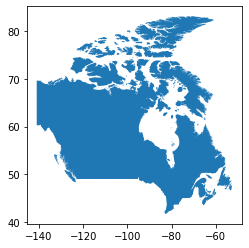

In [21]:
world[world.NAME=='Canada'].geometry.plot()

Looks pretty similar to how we would access a regular series, right?

### Task 3.1: Specifying a New Geometry

Unlike shapefiles, GeoPandas can handle multiple geometry types in different columns. If plotting the data frame then only one can be _active_, but no data is lost.

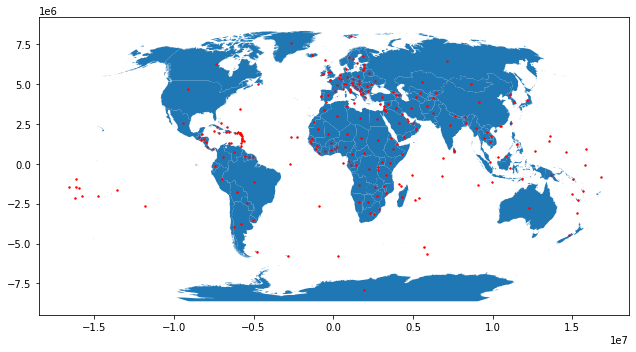

In [34]:
world2['ctr_geom'] = world2.centroid

fig, ax = plt.subplots(1,1,figsize=(12,5))
world2.geometry.plot(ax=ax)
world2.ctr_geom.plot(ax=ax, markersize=2, color='red')
plt.tight_layout()

See [the documentation](https://geopandas.org/data_structures.html#geodataframe) for details about how to rename columns and activate different geometry columns for plotting.

And note that each GeoSeries can have its own CRS:

ESRI:54030
EPSG:3395


<AxesSubplot:>

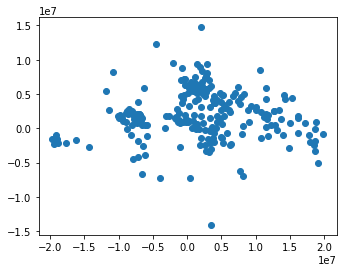

In [33]:
world2['ctr_geom'] = world2.ctr_geom.to_crs('EPSG:3395')
print(world2.geometry.crs)
print(world2.ctr_geom.crs)
world2.ctr_geom.plot()

Don't forget categorical:
```python
db.plot(column="INEGI", 
        categorical=True, 
        legend=True
       )
```

In [69]:
xrange = [0.5, -0.5]
yrange = [0.25, -0.25]
scale  = int(float('1e7')) # This is the scale 

bbox   = 'POLYGON(('

for c in [0,1]:
    bbox += f"{xrange[c]*scale} {yrange[c]*scale}, {xrange[c]*scale} {yrange[c-1]*scale}, "
bbox += f"{xrange[0]*scale} {yrange[0]*scale}"
bbox += '))'
print(bbox)

POLYGON((5000000.0 2500000.0, 5000000.0 -2500000.0, -5000000.0 -2500000.0, -5000000.0 2500000.0, 5000000.0 2500000.0))


<AxesSubplot:>

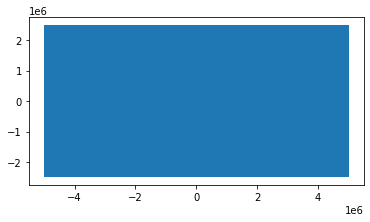

In [70]:
from shapely import wkt
bgdf = gpd.GeoDataFrame({'id':[0], 'coordinates':bbox})
bgdf['geometry'] = bgdf.coordinates.apply(wkt.loads)
bgdf = bgdf.set_crs(world2.crs)
bgdf.plot()

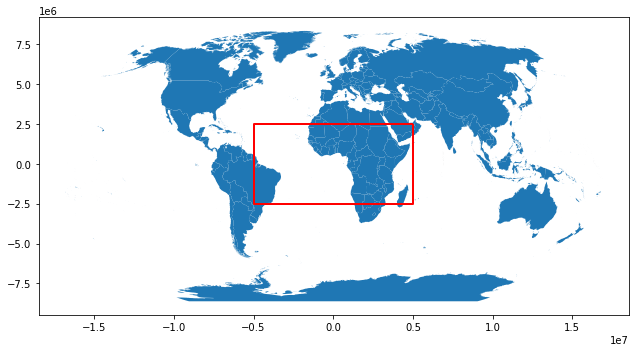

In [72]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
world2.plot(ax=ax)
bgdf.plot(ax=ax, edgecolor='red', color='none', linewidth=2)
plt.tight_layout()

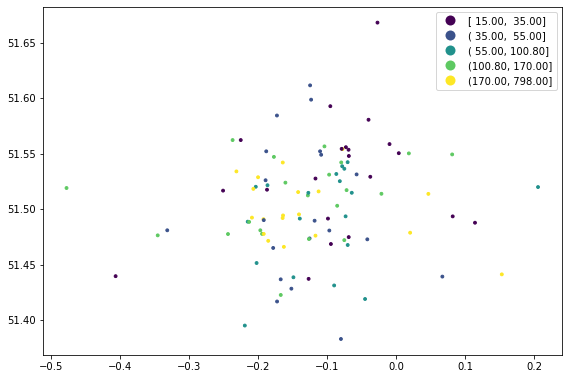

In [95]:
f, ax = plt.subplots(1,1,figsize=(8,6))
url = 'https://bit.ly/3owocdI'
df  = pd.read_csv(url)
df['price'] = df.price.str.replace('$','').str.replace(',','').astype('float')

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude'], crs='epsg:4326'))
gdf.plot(column='price', cmap='viridis', scheme='quantiles', markersize=8, legend=True, ax=ax)
plt.tight_layout()
plt.savefig(os.path.join('..','..','i2p','lectures','img','scattermap.png'), dpi=150, transparent=True)

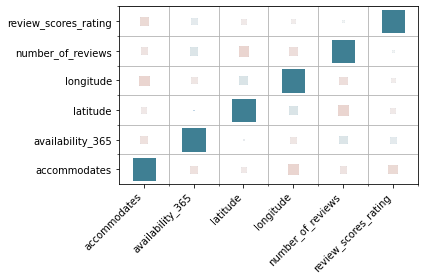

In [108]:
# https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
import seaborn as sns 

def heatmap(x, y, size, color):
    fig, ax = plt.subplots()
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
    
    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5]) 
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    
    n_colors = 256 # Use 256 colors for the diverging color palette
    palette = sns.diverging_palette(20, 220, n=n_colors) # Create the palette
    color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation
    
    def value_to_color(val):
        val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
        ind = int(val_position * (n_colors - 1)) # target index in the color palette
        return palette[ind]
    
    ax.scatter(
        x=x.map(x_to_num),
        y=y.map(y_to_num),
        s=size * size_scale,
        c=color.apply(value_to_color), # Vector of square color values, mapped to color palette
        marker='s'
    )
    
#data = pd.read_csv('https://raw.githubusercontent.com/drazenz/heatmap/master/autos.clean.csv')
columns = ['latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 
           'availability_365', 'number_of_reviews', 'review_scores_rating',]
corr = df[columns].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs(),
    color = corr['value']
)
plt.tight_layout()
plt.savefig(os.path.join('..','..','i2p','lectures','img','correlation.png'), dpi=150, transparent=True)